In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np


In [27]:
df = pd.read_csv('customer_data_collection.csv')

In [15]:
df.sample(10)

,Customer_ID,Age,Gender,Location,Browsing_History,Purchase_History,Customer_Segment,Avg_Order_Value,Holiday,Season,Unnamed: 10,combined_text,Segment
4189,C5189,51,Other,Delhi,"['Books', 'Fitness']","['Non-fiction', 'Yoga Mat']",New Visitor,1407.74,No,Winter,NaN,"Browsed: ['Books', 'Fitness']. Purchased: ['No...",1
5801,C6801,50,Male,Kolkata,"['Fitness', 'Books']","['Treadmill', 'Comics']",Frequent Buyer,1303.40,Yes,Autumn,NaN,"Browsed: ['Fitness', 'Books']. Purchased: ['Tr...",1
6551,C7551,47,Other,Bangalore,"['Fashion', 'Books', 'Home Decor']","['Shoes', 'Biography', 'Wall Art']",Occasional Shopper,2817.20,No,Winter,NaN,"Browsed: ['Fashion', 'Books', 'Home Decor']. P...",2
5901,C6901,46,Female,Bangalore,"['Beauty', 'Home Decor']","['Lipstick', 'Lamp']",Occasional Shopper,2417.29,Yes,Autumn,NaN,"Browsed: ['Beauty', 'Home Decor']. Purchased: ...",1
5754,C6754,43,Female,Chennai,"['Home Decor', 'Books', 'Fitness']","['Wall Art', 'Fiction', 'Dumbbells']",New Visitor,1483.52,No,Summer,NaN,"Browsed: ['Home Decor', 'Books', 'Fitness']. P...",1
788,C1788,48,Female,Mumbai,['Home Decor'],['Cushions'],Occasional Shopper,3678.07,No,Autumn,NaN,Browsed: ['Home Decor']. Purchased: ['Cushions'],2
7732,C8732,60,Female,Delhi,"['Books', 'Electronics', 'Fitness']","['Biography', 'Laptop', 'Resistance Bands']",New Visitor,540.21,No,Spring,NaN,"Browsed: ['Books', 'Electronics', 'Fitness']. ...",1
5872,C6872,29,Female,Bangalore,['Fashion'],['T-shirt'],New Visitor,1810.99,No,Autumn,NaN,Browsed: ['Fashion']. Purchased: ['T-shirt'],0
5182,C6182,25,Female,Kolkata,"['Beauty', 'Electronics']","['Lipstick', 'Smartwatch']",Frequent Buyer,2796.84,Yes,Winter,NaN,"Browsed: ['Beauty', 'Electronics']. Purchased:...",0
9138,C10138,40,Male,Bangalore,"['Beauty', 'Fashion']","['Lipstick', 'Jacket']",Occasional Shopper,653.26,Yes,Winter,NaN,"Browsed: ['Beauty', 'Fashion']. Purchased: ['L...",1


In [24]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer


# --------------------------------------------------
# Approach 1: BERT Embeddings + Numerical Features (Optimized)
# --------------------------------------------------

# Convert string representations to actual lists
df['Browsing_History'] = df['Browsing_History'].apply(ast.literal_eval)
df['Purchase_History'] = df['Purchase_History'].apply(ast.literal_eval)

# 1. Text Feature Engineering with BERT
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model

# Generate separate embeddings for browsing and purchase history
df['Browsing_Str'] = df['Browsing_History'].apply(lambda x: ', '.join(x))
df['Purchase_Str'] = df['Purchase_History'].apply(lambda x: ', '.join(x))

browsing_emb = model.encode(df['Browsing_Str'].tolist())
purchase_emb = model.encode(df['Purchase_Str'].tolist())

# Combine and reduce dimensionality
text_embeddings = np.hstack((browsing_emb, purchase_emb))
pca = PCA(n_components=10)  # Reduce to 10 dimensions
text_embeddings_reduced = pca.fit_transform(text_embeddings)

# 2. Numerical Feature Processing
scaler = StandardScaler()
numeric_features = scaler.fit_transform(df[['Age', 'Avg_Order_Value']])

# 3. Combine Features with Balanced Scaling
# Scale text features to [0,1] range
text_scaler = MinMaxScaler()
text_features_scaled = text_scaler.fit_transform(text_embeddings_reduced)

# Combine all features
final_features = np.hstack((text_features_scaled, numeric_features))

# 4. Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment_BERT'] = kmeans.fit_predict(final_features)




Silhouette Score (BERT): 0.27


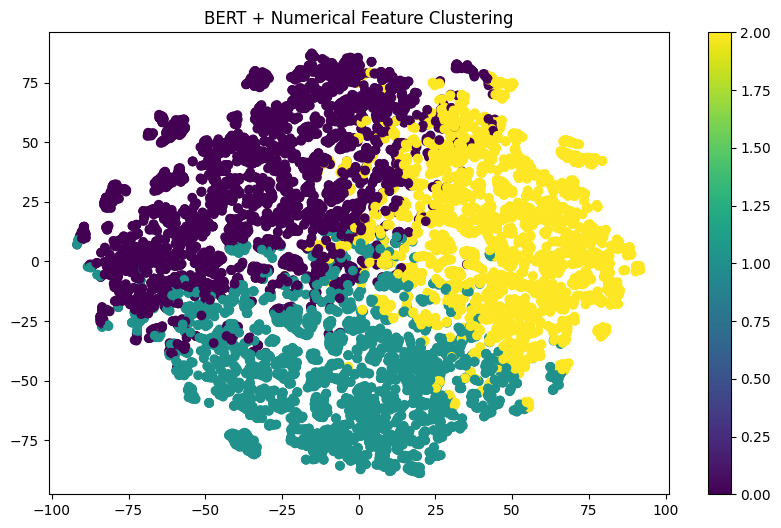

In [25]:
# 5. Evaluation
print(f"Silhouette Score (BERT): {silhouette_score(final_features, df['Segment_BERT']):.2f}")

# Visualization
tsne = TSNE(n_components=2, random_state=42)
vis_features = tsne.fit_transform(final_features)

plt.figure(figsize=(10, 6))
plt.scatter(vis_features[:, 0], vis_features[:, 1], c=df['Segment_BERT'], cmap='viridis')
plt.title("BERT + Numerical Feature Clustering")
plt.colorbar()
plt.show()

In [3]:
import pandas as pd
import numpy as np
import ast
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# 1. Training and Saving the Model =============================================

def train_and_save_model(df, save_path='customer_segmenter.joblib'):
    # Convert string lists to actual lists
    df['Browsing_History'] = df['Browsing_History'].apply(ast.literal_eval)
    df['Purchase_History'] = df['Purchase_History'].apply(ast.literal_eval)

    # Text Processing
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings
    df['Browsing_Str'] = df['Browsing_History'].apply(lambda x: ', '.join(x))
    df['Purchase_Str'] = df['Purchase_History'].apply(lambda x: ', '.join(x))

    browsing_emb = model.encode(df['Browsing_Str'].tolist())
    purchase_emb = model.encode(df['Purchase_Str'].tolist())
    text_embeddings = np.hstack((browsing_emb, purchase_emb))

    # Dimensionality reduction
    pca = PCA(n_components=10)
    text_embeddings_reduced = pca.fit_transform(text_embeddings)

    # Numerical features
    numeric_scaler = StandardScaler()
    numeric_features = numeric_scaler.fit_transform(df[['Age', 'Avg_Order_Value']])

    # Combine features
    text_scaler = MinMaxScaler()
    text_features = text_scaler.fit_transform(text_embeddings_reduced)
    final_features = np.hstack((text_features, numeric_features))

    # Clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(final_features)

    # Create cluster to segment mapping
    cluster_map = {}
    for cluster_id in range(3):
        cluster_data = df[clusters == cluster_id]
        most_common = cluster_data['Customer_Segment'].mode()[0]
        cluster_map[cluster_id] = most_common

    # Create pipeline
    pipeline = Pipeline([
        ('pca', pca),
        ('text_scaler', text_scaler),
        ('numeric_scaler', numeric_scaler),
        ('kmeans', kmeans)
    ])

    # Save components
    joblib.dump({
        'pipeline': pipeline,
        'bert_model': model,
        'cluster_map': cluster_map
    }, save_path)

    return cluster_map

# 2. Prediction Function ======================================================

class CustomerSegmenter:
    def __init__(self, model_path):
        components = joblib.load(model_path)
        self.pipeline = components['pipeline']
        self.bert_model = components['bert_model']
        self.cluster_map = components['cluster_map']

    def preprocess_input(self, data):
        # Convert lists if they're strings
        if isinstance(data['Browsing_History'], str):
            data['Browsing_History'] = ast.literal_eval(data['Browsing_History'])
        if isinstance(data['Purchase_History'], str):
            data['Purchase_History'] = ast.literal_eval(data['Purchase_History'])

        return data

    def predict(self, input_data):
        # Preprocess
        input_data = self.preprocess_input(input_data)

        # Generate embeddings
        browsing_str = ', '.join(input_data['Browsing_History'])
        purchase_str = ', '.join(input_data['Purchase_History'])

        browsing_emb = self.bert_model.encode([browsing_str])
        purchase_emb = self.bert_model.encode([purchase_str])
        text_emb = np.hstack((browsing_emb, purchase_emb))

        # Transform through pipeline
        text_emb_pca = self.pipeline.named_steps['pca'].transform(text_emb)
        text_emb_scaled = self.pipeline.named_steps['text_scaler'].transform(text_emb_pca)

        numeric_features = np.array([
            input_data['Age'],
            input_data['Avg_Order_Value']
        ]).reshape(1, -1)
        numeric_scaled = self.pipeline.named_steps['numeric_scaler'].transform(numeric_features)

        combined = np.hstack((text_emb_scaled, numeric_scaled))

        # Predict
        cluster = self.pipeline.named_steps['kmeans'].predict(combined)[0]
        return self.cluster_map[cluster]

# 3. Usage Example ============================================================

if __name__ == "__main__":
    # First train and save the model (do this once)
    cust_df = pd.read_csv('customer_data_collection.csv')
    cluster_map = train_and_save_model(cust_df, 'segmenter_model.joblib')
    print("Cluster mapping:", cluster_map)

    # Then load and use the model
    segmenter = CustomerSegmenter('segmenter_model.joblib')

    # Example prediction
    new_customer = {
        'Age': 32,
        'Avg_Order_Value': 3500.00,
        'Browsing_History': ['Electronics', 'Fashion'],
        'Purchase_History': ['Smartphone', 'Jeans']
    }

    prediction = segmenter.predict(new_customer)
    print(f"Predicted Segment: {prediction}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cluster mapping: {0: 'New Visitor', 1: 'Occasional Shopper', 2: 'Occasional Shopper'}
Predicted Segment: New Visitor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1]:
import pandas as pd
import ast
from typing import Dict, List

class RecommendationEngine:
    def __init__(self, products_df: pd.DataFrame):
        self.products = products_df
        self.location_mapping = {  # Map cities to countries
            'Chennai': 'India',
            'Delhi': 'India',
            'Bangalore': 'India',
            'Kolkata': 'India',
            'Mumbai': 'India'
        }

        # Define recommendation rules for each segment
        self.segment_rules = {
            'New Visitor': {
                'sort_columns': ['Probability_of_Recommendation', 'Product_Rating'],
                'sort_ascending': [False, False],
                'filters': [
                    ('Price', '<=', 2500),  # Focus on affordable items
                    ('Customer_Review_Sentiment_Score', '>=', 0.5)
                ]
            },
            'Occasional Shopper': {
                'sort_columns': ['Average_Rating_of_Similar_Products', 'Price'],
                'sort_ascending': [False, True],
                'filters': [
                    ('Product_Rating', '>=', 3.0),
                    ('Customer_Review_Sentiment_Score', '>=', 0.6)
                ]
            },
            'Frequent Buyer': {
                'sort_columns': ['Price', 'Probability_of_Recommendation'],
                'sort_ascending': [False, False],  # Premium items first
                'filters': [
                    ('Product_Rating', '>=', 4.0),
                    ('Price', '>=', 1500)
                ]
            }
        }

    def _map_location(self, customer_location: str) -> str:
        return self.location_mapping.get(customer_location, 'India')

    def get_recommendations(self,
                           customer_data: Dict,
                           segment: str,
                           top_n: int = 5) -> List[Dict]:
        # Validate input
        if segment not in self.segment_rules:
            raise ValueError(f"Invalid segment: {segment}")

        # Get customer context
        country = self._map_location(customer_data['Location'])
        season = customer_data['Season']
        holiday = customer_data['Holiday']

        # Filter products by context
        filtered = self.products[
            (self.products['Geographical_Location'] == country) &
            (self.products['Season'] == season) &
            (self.products['Holiday'] == holiday)
        ]

        # Apply segment-specific filters
        rules = self.segment_rules[segment]
        for column, op, value in rules['filters']:
            if op == '<=':
                filtered = filtered[filtered[column] <= value]
            elif op == '>=':
                filtered = filtered[filtered[column] >= value]
            # Add more operators as needed

        # Sort products
        sorted_products = filtered.sort_values(
            by=rules['sort_columns'],
            ascending=rules['sort_ascending']
        )

        # Get top N recommendations
        recommendations = sorted_products.head(top_n)

        # Convert to list of dicts
        return recommendations.to_dict('records')

# Sample Usage ----------------------------------------------------------------

# Load product data
products_df = pd.read_csv('product_recommendation_data.csv')

# Convert string lists to actual lists
products_df['Similar_Product_List'] = products_df['Similar_Product_List'].apply(ast.literal_eval)

# Initialize engine
engine = RecommendationEngine(products_df)

# Sample customer data (from segmentation output)
customer_example = {
    'Customer_ID': 'C1000',
    'Location': 'Chennai',
    'Season': 'Winter',
    'Holiday': 'No',
    'Segment': 'New Visitor'
}

# Get recommendations
recs = engine.get_recommendations(
    customer_data=customer_example,
    segment=customer_example['Segment'],
    top_n=3
)

print("Recommended Products:")
for product in recs:
    print(f"{product['Product_ID']}: {product['Category']} - {product['Subcategory']} (₹{product['Price']})")

Recommended Products:
P8663: Fashion - T-shirt (₹2169)
P7207: Home Decor - Curtains (₹2176)
P5656: Fitness - Dumbbells (₹1493)


In [4]:
# Segmentize model

# Then load and use the model
segmenter = CustomerSegmenter('segmenter_model.joblib')

# Example prediction
new_customer = {
    'Age': 32,
    'Avg_Order_Value': 3500.00,
    'Browsing_History': ['Electronics', 'Fashion'],
    'Purchase_History': ['Smartphone', 'Jeans']
}

prediction = segmenter.predict(new_customer)
print(f"Predicted Segment: {prediction}")


# Initialize RecommendationEngine
engine = RecommendationEngine(products_df)

# Sample customer data (from segmentation output)
customer_example = {
    'Customer_ID': 'C1000',
    'Location': 'Chennai',
    'Season': 'Winter',
    'Holiday': 'No',
    'Segment': 'New Visitor'
}

# Get recommendations
recs = engine.get_recommendations(
    customer_data=customer_example,
    segment=customer_example['Segment'],
    top_n=3
)

print("Recommended Products:")
for product in recs:
    print(f"{product['Product_ID']}: {product['Category']} - {product['Subcategory']} (₹{product['Price']})")

Predicted Segment: New Visitor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.2 MB/s eta 0:00:00


In [10]:
import os
from typing import List, Dict, Any, Optional
from pydantic import BaseModel, Field
import google.generativeai as genai
from langgraph.graph import StateGraph, END

# Configuration
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY", "Api_key")
genai.configure(api_key=GOOGLE_API_KEY)

# Agent State Model
class AgentState(BaseModel):
    customer_data: Optional[Dict[str, Any]] = None
    segment: Optional[str] = None
    recommendations: Optional[List[Dict[str, Any]]] = None
    next_step: str = "segmentize"
    final_response: Optional[str] = None

# Initialize your existing tools
segmenter = CustomerSegmenter('segmenter_model.joblib')
# Assuming products_df is available or loaded elsewhere
engine = RecommendationEngine(products_df)

# Define tool functions that use your existing code
def segmentize_customer(state: AgentState) -> AgentState:
    """Use existing CustomerSegmenter to segment the customer."""
    customer_data = {
        'Age': state.customer_data.get('Age'),
        'Avg_Order_Value': state.customer_data.get('Avg_Order_Value'),
        'Browsing_History': state.customer_data.get('Browsing_History'),
        'Purchase_History': state.customer_data.get('Purchase_History')
    }

    # Use your existing segmenter to make prediction
    segment = segmenter.predict(customer_data)

    # Update state
    state.segment = segment
    state.next_step = "recommend"
    return state

def recommend_products(state: AgentState) -> AgentState:
    """Use existing RecommendationEngine to get product recommendations."""
    customer_data = {
        'Customer_ID': state.customer_data.get('Customer_ID'),
        'Location': state.customer_data.get('Location'),
        'Season': state.customer_data.get('Season'),
        'Holiday': state.customer_data.get('Holiday'),
        'Segment': state.segment
    }

    # Use your existing recommendation engine
    recommendations = engine.get_recommendations(
        customer_data=customer_data,
        segment=state.segment,
        top_n=3
    )

    # Update state
    state.recommendations = recommendations
    state.next_step = "summarize"
    return state

def generate_response(state: AgentState) -> AgentState:
    """Use Gemini to generate a personalized response with recommendations."""
    model = genai.GenerativeModel('gemini-1.5-pro')

    segment = state.segment
    recommendations = state.recommendations
    customer_data = state.customer_data

    # Format recommendations for display
    recommendation_text = ""
    for product in recommendations:
        recommendation_text += f"- {product['Product_ID']}: {product['Category']} - {product['Subcategory']} (₹{product['Price']})\n"

    prompt = f"""
    Generate a personalized product recommendation message for a customer with the following details:
    - ID: {customer_data.get('Customer_ID')}
    - Age: {customer_data.get('Age')}
    - Gender: {customer_data.get('Gender')}
    - Location: {customer_data.get('Location')}
    - Season: {customer_data.get('Season')}
    - Customer Segment: {segment}

    Recommended Products:
    {recommendation_text}

    The response should be friendly, personalized, and explain
    why these products are being recommended based on their segment and other factors.

    IMPORTANT: Use "Tata CLiQ" as the brand name throughout the message.
    Do not use placeholders like [Your Brand Name].
    """

    response = model.generate_content(prompt)
    state.final_response = response.text
    state.next_step = "end"
    return state

# Define the LangGraph workflow
def build_recommendation_graph():
    # Create a new graph
    graph = StateGraph(AgentState)

    # Add nodes
    graph.add_node("segmentize", segmentize_customer)
    graph.add_node("recommend", recommend_products)
    graph.add_node("summarize", generate_response)

    # Add edges - define the workflow
    graph.add_edge("segmentize", "recommend")
    graph.add_edge("recommend", "summarize")
    graph.add_edge("summarize", END)

    # Set entry point
    graph.set_entry_point("segmentize")

    return graph.compile()

# Create the agent class
class RecommendationAgent:
    def __init__(self):
        self.workflow = build_recommendation_graph()

    def process_customer(self, customer_data: Dict[str, Any]) -> str:
        """Process customer data and return personalized recommendations."""
        # Initialize state
        initial_state = AgentState(customer_data=customer_data)

        # Execute the graph
        result = self.workflow.invoke(initial_state)

        return result

# Example usage
if __name__ == "__main__":
    # Sample customer data for testing
    sample_customer = {
        'Customer_ID': 'C1234',
        'Age': 32,
        'Gender': 'Female',
        'Location': 'Chennai',
        'Browsing_History': ['Electronics', 'Fashion'],
        'Purchase_History': ['Smartphone', 'Jeans'],
        'Avg_Order_Value': 3500.00,
        'Holiday': 'No',
        'Season': 'Winter'
    }

    # Initialize and run the agent
    agent = RecommendationAgent()
    response = agent.process_customer(sample_customer)
    print(response)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'customer_data': {'Customer_ID': 'C1234', 'Age': 32, 'Gender': 'Female', 'Location': 'Chennai', 'Browsing_History': ['Electronics', 'Fashion'], 'Purchase_History': ['Smartphone', 'Jeans'], 'Avg_Order_Value': 3500.0, 'Holiday': 'No', 'Season': 'Winter'}, 'segment': 'New Visitor', 'recommendations': [{'Product_ID': 'P8663', 'Category': 'Fashion', 'Subcategory': 'T-shirt', 'Price': 2169, 'Brand': 'Brand B', 'Average_Rating_of_Similar_Products': 3.0, 'Product_Rating': 4.2, 'Customer_Review_Sentiment_Score': 0.51, 'Holiday': 'No', 'Season': 'Winter', 'Geographical_Location': 'India', 'Similar_Product_List': ['T-shirt'], 'Probability_of_Recommendation': 0.95, 'Unnamed: 13': nan, 'Unnamed: 14': nan}, {'Product_ID': 'P7207', 'Category': 'Home Decor', 'Subcategory': 'Curtains', 'Price': 2176, 'Brand': 'Brand B', 'Average_Rating_of_Similar_Products': 3.8, 'Product_Rating': 3.6, 'Customer_Review_Sentiment_Score': 0.66, 'Holiday': 'No', 'Season': 'Winter', 'Geographical_Location': 'India', 'Simil

In [11]:
response

{'customer_data': {'Customer_ID': 'C1234',
  'Age': 32,
  'Gender': 'Female',
  'Location': 'Chennai',
  'Browsing_History': ['Electronics', 'Fashion'],
  'Purchase_History': ['Smartphone', 'Jeans'],
  'Avg_Order_Value': 3500.0,
  'Holiday': 'No',
  'Season': 'Winter'},
 'segment': 'New Visitor',
 'recommendations': [{'Product_ID': 'P8663',
   'Category': 'Fashion',
   'Subcategory': 'T-shirt',
   'Price': 2169,
   'Brand': 'Brand B',
   'Average_Rating_of_Similar_Products': 3.0,
   'Product_Rating': 4.2,
   'Customer_Review_Sentiment_Score': 0.51,
   'Holiday': 'No',
   'Season': 'Winter',
   'Geographical_Location': 'India',
   'Similar_Product_List': ['T-shirt'],
   'Probability_of_Recommendation': 0.95,
   'Unnamed: 13': nan,
   'Unnamed: 14': nan},
  {'Product_ID': 'P7207',
   'Category': 'Home Decor',
   'Subcategory': 'Curtains',
   'Price': 2176,
   'Brand': 'Brand B',
   'Average_Rating_of_Similar_Products': 3.8,
   'Product_Rating': 3.6,
   'Customer_Review_Sentiment_Score': 